In [1]:
## Install necessary libraries
# %pip install -q -r ../requirements.txt

In [1]:
# Configure tensorflow for M1 CPU
import tensorflow as tf

physical_gpus = tf.config.list_physical_devices('GPU')
print("Available GPUs:", physical_gpus)

try:
    tf.keras.mixed_precision.set_global_policy('float32')
    tf.config.experimental.set_virtual_device_configuration(
        physical_gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=56320)]  # Limit RAM to 55GB to avoid starving PC
    )
    print("Using GPU with 55GB of memory")
except Exception as e:
    print(e)

# Constants
IMG_SIZE = 224
BATCH_SIZE = 5000
AUTOTUNE = tf.data.AUTOTUNE
EPOCHS = 5
tf.random.set_seed(42)


Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Using GPU with 55GB of memory


In [2]:
import tensorflow_datasets as tfds
from tensorflow.keras.applications.resnet50 import preprocess_input


def prepare_input_data(input):
    # image = tf.cast(data['image'], tf.float32)
    image = tf.image.resize(input['image'], (IMG_SIZE, IMG_SIZE))
    image = preprocess_input(image)
    label = input['label']
    return image, label

# Load ImageNet
dataset, info = tfds.load(
    'imagenette',
    shuffle_files=False,
    with_info=True,
    data_dir='../datasets'  # path to manual downloaded ImageNet dataset
)

# Dataset stats
print(f'Train count: {info.splits['train'].num_examples}')
print(f'Test count: {info.splits['validation'].num_examples}')

# Preprocess data
# train_dataset = dataset['train'].map(prepare_input_data, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)
# test_dataset = dataset['validation'].map(prepare_input_data, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

/Users/stanleyokwii/Documents/Birkbeck/Msc Project/msc-project-source-code-files-24-25-Stanley-Okwii/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dl Completed...: 0 url [00:00, ? url/s]
Dl Completed...: 100%|██████████| 1/1 [02:47<00:00, 88.11s/ url]

Dl Completed...: 100%|██████████| 1/1 [02:48<00:00, 88.11s/ url]

Dl Completed...: 100%|██████████| 1/1 [02:49<00:00, 88.11s/ url]

Dl Completed...: 100%|██████████| 1/1 [02:50<00:00, 88.11s/ url]

Dl Completed...: 100%|██████████| 1/1 [02:51<00:00, 88.11s/ url]

Dl Completed...: 100%|██████████| 1/1 [02:52<00:00, 88.11s/ url]

Dl Completed...: 100%|██████████| 1/1 [02:53<00:00, 88.11s/ url]

Dl Completed...: 100%|██████████| 1/1 [02:54<00:00, 88.11s/ url]

Dl Completed...: 100%|██████████| 1/1 [02:55<00:00, 88.11s/ url]

Dl Completed...: 100%|██████████| 1/1 [02:56<00:00, 88.11s/ url]

Dl Completed...: 100%|██████████| 1/1 [02:57<00:00, 88.11s/ url]

Dl Completed...: 100%|██████████| 1/1 [02:58<00:00, 88.11s/ url]

Dl Completed...: 100%|██████████| 1/1 [02:59<00:00, 88.11s/ url]

Dl Completed...: 100%|██████████| 1/1 [03:00<00:00, 88.11s/ url]

Dl Completed...: 100%|██████████| 1/

Dataset imagenette downloaded and prepared to ../datasets/imagenette/full-size-v2/1.0.0. Subsequent calls will reuse this data.
Train count: 9469
Test count: 3925


2025-08-05 21:31:47.720679: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2025-08-05 21:31:47.720720: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2025-08-05 21:31:47.720729: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2025-08-05 21:31:47.720764: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-08-05 21:31:47.720777: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


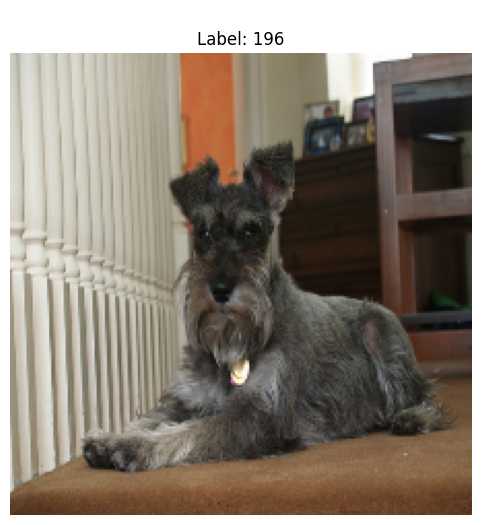

2025-07-16 15:26:58.545416: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [4]:
import matplotlib.pyplot as plt
import numpy as np


def deprocess_image(processed_img):
    """
    Reverses the preprocessing done by tf.keras.applications.resnet50.preprocess_input.
    """
    # Create a copy to avoid modifying the original tensor
    img = processed_img.copy()

    # The preprocess_input function for ResNet50 subtracts the mean BGR pixel values.
    # To reverse this, we add them back.
    # Mean pixel values for BGR: [103.939, 116.779, 123.68]
    img[:, :, 0] += 103.939  # Blue
    img[:, :, 1] += 116.779  # Green
    img[:, :, 2] += 123.68   # Red

    # The preprocess_input function also converts from RGB to BGR.
    # We need to convert it back to RGB for display.
    img = img[..., ::-1]

    # Clip the values to the valid range [0, 255] and convert to an integer type
    img = np.clip(img, 0, 255).astype('uint8')

    return img

# Get the first batch from the test dataset
for images, labels in train_dataset.take(1):
    # Select the very first image from the batch
    first_image = images[0].numpy()
    first_label = labels[0].numpy()

    # Reverse the preprocessing to make it viewable
    display_image = deprocess_image(first_image)

    # Display the image
    plt.figure(figsize=(6, 6))
    plt.imshow(display_image)
    plt.title(f"\nLabel: {first_label}")
    plt.axis('off') # Hide the axes for a cleaner look
    plt.show()


In [3]:
# Load ResNet50 model
from tensorflow.keras.applications import ResNet50

# Fixes SSL certificate verification issue when downloading model
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

base_model = ResNet50(
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
)

In [5]:
# Evaluate model
base_model.compile(
    optimizer='adam', # The optimizer choice doesn't impact evaluation results
    loss='sparse_categorical_crossentropy',
    metrics=[
        'sparse_categorical_accuracy', # Top-1 accuracy
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top_5_accuracy')
    ]
)

# results = base_model.evaluate(test_dataset, verbose=1, batch_size=5000, steps=5)

# print("\n--- Evaluation Results ---")
# print(f"Loss: {results[0]:.4f}")
# print(f"Top-1 Accuracy: {results[1] * 100:.2f}%")
# print(f"Top-5 Accuracy: {results[2] * 100:.2f}%") # 5, 2.5 89.54%
# """
# Loss: 1.2469
# Top-1 Accuracy: 70.57%
# Top-5 Accuracy: 89.76%
# """

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

tf.debugging.set_log_device_placement(False)
# --- Configuration and Constants ---
# Set image dimensions and batching parameters.
IMG_SIZE = 224
BATCH_SIZE = 200
AUTOTUNE = tf.data.experimental.AUTOTUNE

def prepare_input_data(input_data):
    """
    Args:
        input_data: A dictionary containing 'image' and 'label' from tfds.

    Returns:
        A tuple containing the preprocessed image and its corresponding label.
    """
    image = tf.image.resize(input_data['image'], (IMG_SIZE, IMG_SIZE))
    image = preprocess_input(image)
    label = input_data['label']
    return image, label

def pgd_attack_from_scratch(model, images, labels, eps, eps_iter, nb_iter):
    """
    Implements the Projected Gradient Descent (PGD) attack from scratch.

    This function generates adversarial examples by iteratively applying a small
    perturbation in the direction of the gradient of the loss, and then
    projecting the result back into the epsilon-ball of the original image.

    Args:
        model (tf.keras.Model): The model to attack.
        images (tf.Tensor): The original, clean input images.
        labels (tf.Tensor): The true labels for the images.
        eps (float): The maximum perturbation (L-infinity norm).
        eps_iter (float): The step size for each attack iteration.
        nb_iter (int): The number of PGD iterations to perform.

    Returns:
        tf.Tensor: The generated adversarial images.
    """
    # Start with the original images
    x_adv = tf.identity(images)
    # Use sparse categorical crossentropy for the loss calculation
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

    # Loop for the number of iterations
    for _ in range(nb_iter):
        with tf.GradientTape() as tape:
            # Watch the adversarial images tensor for gradient calculation
            tape.watch(x_adv)
            # Get model predictions for the current adversarial images
            prediction = model(x_adv, training=False)
            # Calculate the loss against the true labels
            loss = loss_object(labels, prediction)

        # Get the gradients of the loss with respect to the adversarial images
        gradients = tape.gradient(loss, x_adv)
        
        # Calculate the sign of the gradients
        signed_grad = tf.sign(gradients)
        
        # Update the adversarial image by taking a small step in the direction of the gradient
        x_adv = x_adv + eps_iter * signed_grad
        
        # Project the perturbation back to the epsilon-ball around the original image
        perturbation = tf.clip_by_value(x_adv - images, -eps, eps)
        x_adv = images + perturbation
        
        # Note: We don't explicitly clip the final pixel values (e.g., to [0, 1])
        # because the input `images` are already preprocessed. The projection step
        # correctly constrains the perturbation within the L-infinity ball.

    return x_adv

def create_adversarial_dataset(original_dataset, model, eps, pgd_steps, pgd_step_size):
    """
    Generates an adversarial dataset using the custom PGD attack.
    Args:
        original_dataset (tf.data.Dataset): The clean dataset to create adversarial examples from.
                                            It should be batched.
        model (tf.keras.Model): The model to generate attacks against.
        eps (float): The epsilon value for the PGD attack, defining the max perturbation.
        pgd_steps (int): The number of PGD steps to run.
        pgd_step_size (float): The step size for each PGD iteration.

    Returns:
        tf.data.Dataset: A new dataset containing the adversarial images and original labels,
                         batched and prefetched for performance.
    """
    print("Starting adversarial dataset generation...")
    adversarial_images = []
    adversarial_labels = []

    # Iterate through each batch in the original dataset
    for i, (images, labels) in enumerate(original_dataset):
        print(f"  Processing batch {i+1}...")
        # Generate adversarial examples for the current batch using our custom function
        adv_images = pgd_attack_from_scratch(
            model=model,
            images=images,
            labels=labels,
            eps=eps,
            eps_iter=pgd_step_size,
            nb_iter=pgd_steps
        )
        
        # Append the results to our lists
        adversarial_images.append(adv_images)
        adversarial_labels.append(labels)

    print("Adversarial generation complete. Creating final dataset.")

    # Concatenate all batches into single tensors
    adversarial_images = tf.concat(adversarial_images, axis=0)
    adversarial_labels = tf.concat(adversarial_labels, axis=0)

    # Create a new dataset from the adversarial examples
    adversarial_dataset = tf.data.Dataset.from_tensor_slices((adversarial_images, adversarial_labels))
    
    # Apply the same batching and prefetching for evaluation compatibility
    adversarial_dataset = adversarial_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    return adversarial_dataset

dataset, info = tfds.load(
    'imagenet2012',
    shuffle_files=False,
    with_info=True,
    data_dir='../datasets',  # Change this to your ImageNet path
)
print("Successfully loaded ImageNet2012 dataset.")
validation_dataset_raw = dataset['validation']

test_dataset = validation_dataset_raw.map(prepare_input_data, num_parallel_calls=AUTOTUNE)\
                                    .batch(BATCH_SIZE)\
                                    .prefetch(AUTOTUNE)\
                                    .take(10) # Using a small subset for a quick example

print("Loading pre-trained ResNet50 model...")
model = ResNet50(weights='imagenet')
model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
# --- 4. Generate the Adversarial Dataset ---
# Define PGD attack parameters
EPSILON = 0.03
PGD_STEPS = 2
PGD_STEP_SIZE = 0.007

adversarial_test_dataset = create_adversarial_dataset(
    original_dataset=test_dataset,
    model=model,
    eps=EPSILON,
    pgd_steps=PGD_STEPS,
    pgd_step_size=PGD_STEP_SIZE
)


In [ ]:
# tf.debugging.set_log_device_placement(False)
# model.evaluate(adversarial_test_dataset)
# results = model.evaluate(adversarial_test_dataset, verbose=1, batch_size=10, steps=2)

# print("\n--- PGD Evaluation Results ---")
# print(f"Loss: {results[0]:.4f}")
# print(f"Top-1 Accuracy: {results[1] * 100:.2f}%")
# print(f"Top-5 Accuracy: {results[2] * 100:.2f}%") # 5, 2.5 89.54%

In [ ]:
# # 1. Create a sample dataset
# def _bytes_feature(value):
#     """Returns a bytes_list from a string / byte."""
#     if isinstance(value, type(tf.constant(0))):
#         value = value.numpy() # get value from EagerTensor
#     return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

# def _int64_feature(value):
#   """Returns an int64_list from a bool / enum / int / uint."""
#   return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

# # 2. Iterate through the dataset and write to a TFRecord file
# tfrecord_filename = 'testdata.tfrecord'

# print(f"Writing to {tfrecord_filename}...")
# with tf.io.TFRecordWriter(tfrecord_filename) as writer:
#     # THE FIX: Loop through each BATCH first
#     for image_batch, label_batch in adversarial_test_dataset:
        
#         # THEN, loop through each example INSIDE the batch
#         for i in range(len(label_batch)):
#             # Get the single image and label
#             image = image_batch[i]
#             label = label_batch[i]

#             # Serialize the single image tensor to a byte string
#             image_bytes = tf.io.serialize_tensor(image)

#             # Create a feature dictionary for the single example
#             # label.numpy() will now correctly be a single integer
#             feature = {
#                 'image': _bytes_feature(image_bytes),
#                 'label': _int64_feature(label.numpy())
#             }
            
#             # Create a tf.train.Example proto and serialize it
#             example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
#             serialized_example = example_proto.SerializeToString()
            
#             # Write the serialized example to the file
#             writer.write(serialized_example)

# print("TFRecord file saved successfully!")


In [14]:
# --- How to load the data back ---
tfrecord_filename = '../datasets/adversaries/test_dataset.tfrecord'
def _parse_function(example_proto):
    """Parses a single example proto and sets the image shape."""
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
    }
    parsed_features = tf.io.parse_single_example(example_proto, feature_description)
    
    # Deserialize the image tensor
    image = tf.io.parse_tensor(parsed_features['image'], out_type=tf.float32)
    label = parsed_features['label']
    
    # --- FIX #1: Explicitly set the shape of the image tensor ---
    # This tells TensorFlow the dimensions of the image.
    image.set_shape([IMG_SIZE, IMG_SIZE, 3])
    
    return image, label

# Load the TFRecord file back into a dataset
loaded_dataset = tf.data.TFRecordDataset(tfrecord_filename)

# Map the parsing function across the dataset
parsed_dataset = loaded_dataset.map(_parse_function)


print("\nReading from TFRecord file:")
for image, label in parsed_dataset.take(1):
    print(f"Loaded image shape: {image.shape}")
    print(f"Loaded label: {label.numpy()}")


Reading from TFRecord file:
Loaded image shape: (224, 224, 3)
Loaded label: 26


2025-07-17 21:48:06.452640: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [11]:
# --- How to load the data back ---
tfrecord_filename = '../datasets/adversaries/test_dataset1.tfrecord'

def _parse_function(example_proto):
    """Parses a single example proto, decodes the JPEG, and normalizes it."""
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
    }
    parsed_features = tf.io.parse_single_example(example_proto, feature_description)
    
    # 1. Decode the JPEG byte string into a uint8 tensor
    image = tf.io.decode_jpeg(parsed_features['image'], channels=3)
    label = parsed_features['label']
    
    # 2. Convert to float32 and normalize to [0, 1] range
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    # --- The shape is now correctly inferred, but setting it explicitly is good practice ---
    # The shape is set after decoding, not before.
    image.set_shape([IMG_SIZE, IMG_SIZE, 3])
    
    return image, label

# Load the TFRecord file back into a dataset
loaded_dataset = tf.data.TFRecordDataset(tfrecord_filename)

# Map the parsing function across the dataset
parsed_dataset = loaded_dataset.map(_parse_function)


print("\nReading from TFRecord file:")
for image, label in parsed_dataset.take(1):
    print(f"Loaded image shape: {image.shape}")
    print(f"Loaded label: {label.numpy()}")


Reading from TFRecord file:
Loaded image shape: (224, 224, 3)
Loaded label: 26


2025-07-17 21:47:01.134607: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [15]:
batched_dataset_for_eval = parsed_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

results = base_model.evaluate(batched_dataset_for_eval, verbose=1, batch_size=10, steps=2)

print("\n--- PGD Evaluation Results ---")
print(f"Loss: {results[0]:.4f}")
print(f"Top-1 Accuracy: {results[1] * 100:.2f}%")

# --- PGD Evaluation Results ---
# Loss: 8.4227
# Top-1 Accuracy: 0.17%

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1.3161 - sparse_categorical_accuracy: 0.7033 - top_5_accuracy: 0.8850

--- PGD Evaluation Results ---
Loss: 1.3161
Top-1 Accuracy: 70.33%


2025-07-17 21:48:32.159980: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-07-17 21:48:32.160001: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10413729852824967575
2025-07-17 21:48:32.160005: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2025-07-17 21:48:32.160010: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15626931849922698437
2025-07-17 21:48:32.160019: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15315982040532858339


In [ ]:
# %whos
# %reset_selective -f validation_dataset_raw
# # %reset -f
# import gc;gc.collect()

# gc.collect()

0